<p style="background-color:#009de1;font-family:tahoma;font-size:30pt;color:white;text-align:center;border-radius:10px; padding-bottom:2.5%; height:70px; line-height:70px;"><b>Credit Score Classification - ANN </b></p>

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import pickle
import re
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, log_loss


# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# To disable warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(False)

# Visualization settings
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

# Pandas Settings
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 200)

# Read the Dataset and Overview

In [2]:
df = pd.read_csv("credit_score_cleaned_train.csv")

In [3]:
df.head()

,id,customer_id,month,name,age,ssn,occupation,annual_income,monthly_inhand_salary,total_emi_per_month,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,49.575,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",3,7,11.270,4,Good,809.980,26.823,265,No,80.415,High_spent_Small_value_payments,312.494,2
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,49.575,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",-1,7,11.270,4,Good,809.980,31.945,266,No,118.280,Low_spent_Large_value_payments,284.629,2
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,49.575,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",3,7,11.270,4,Good,809.980,28.609,267,No,81.700,Low_spent_Medium_value_payments,331.210,2
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,49.575,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",5,4,6.270,4,Good,809.980,31.378,268,No,199.458,Low_spent_Small_value_payments,223.451,2
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,49.575,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal...",6,4,11.270,4,Good,809.980,24.797,269,No,41.420,High_spent_Medium_value_payments,341.489,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        100000 non-null  object 
 1   customer_id               100000 non-null  object 
 2   month                     100000 non-null  object 
 3   name                      100000 non-null  object 
 4   age                       100000 non-null  int64  
 5   ssn                       100000 non-null  object 
 6   occupation                100000 non-null  object 
 7   annual_income             100000 non-null  float64
 8   monthly_inhand_salary     100000 non-null  float64
 9   total_emi_per_month       100000 non-null  float64
 10  num_bank_accounts         100000 non-null  int64  
 11  num_credit_card           100000 non-null  int64  
 12  interest_rate             100000 non-null  int64  
 13  num_of_loan               100000 non-null  in

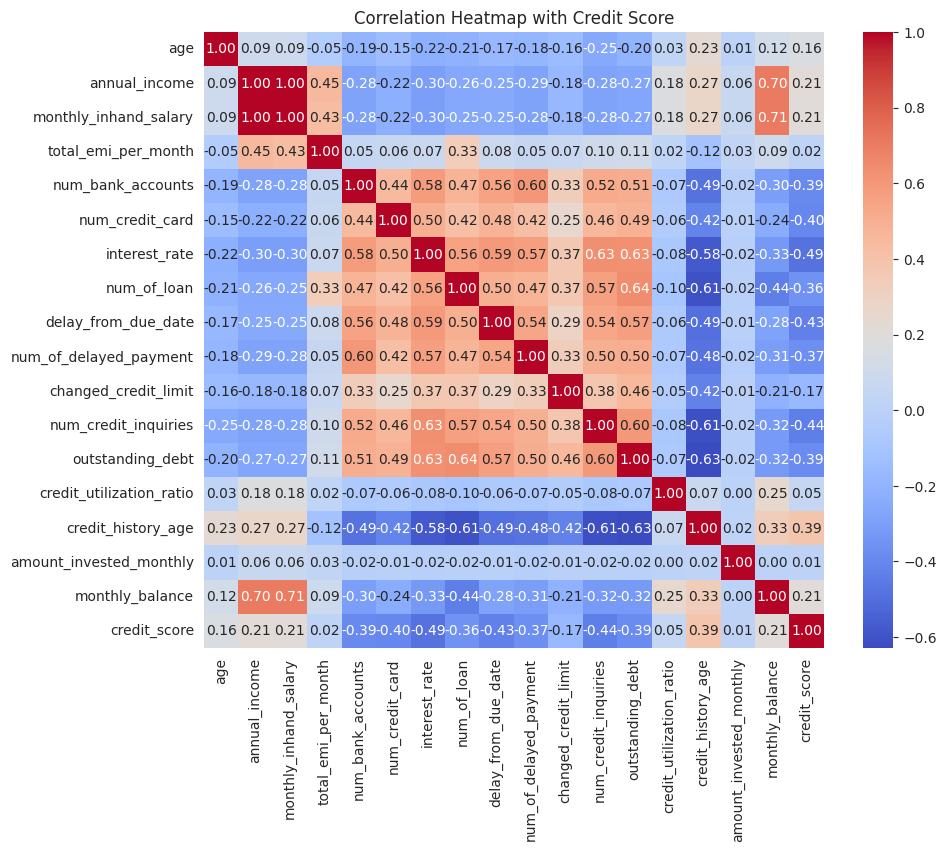

In [5]:
numeric_df = df.select_dtypes(include="number")

plt.figure(figsize=(10, 8))

correlation_matrix = numeric_df.corr()

#Plotting
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Correlation Heatmap with Credit Score")
plt.show()

In [6]:
# Numeric columns in the DataFrame
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

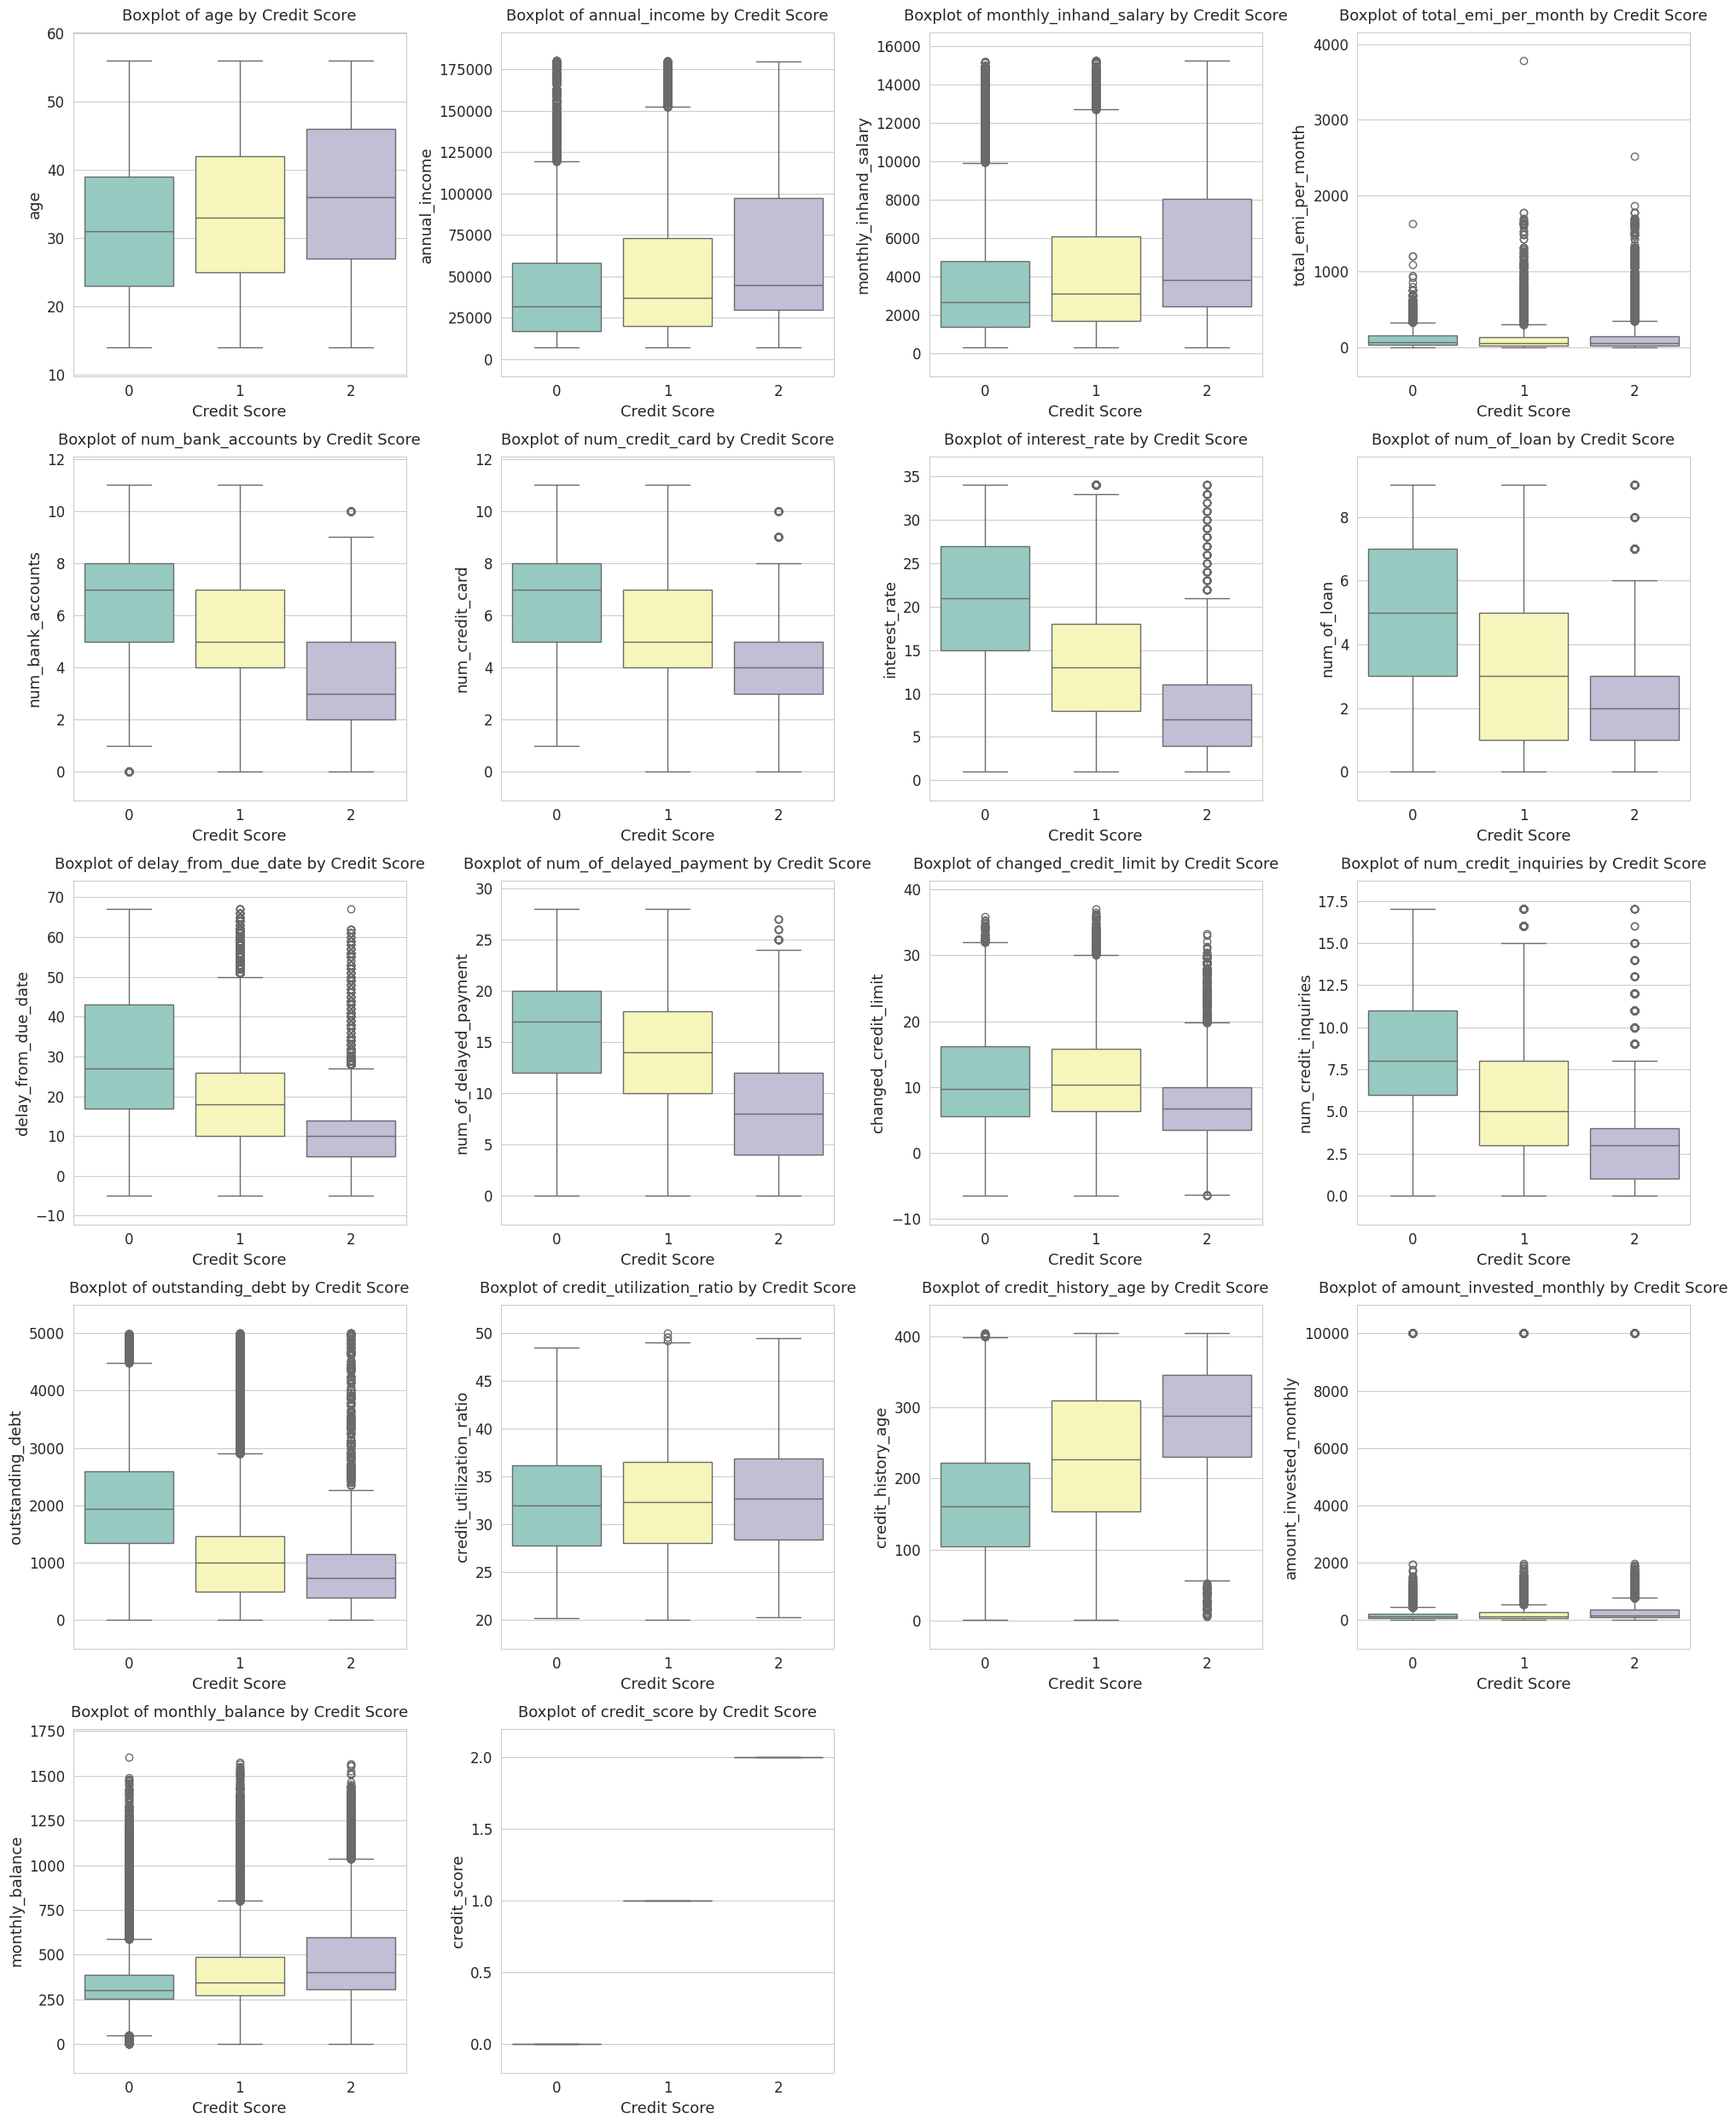

In [7]:

# Calculate number of rows and columns
num_cols = 4
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

# Plotting
for i, col in enumerate(numeric_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x='credit_score', y=col, data=df, palette='Set3')
    plt.title(f'Boxplot of {col} by Credit Score', fontsize=13, pad=10)
    plt.xlabel('Credit Score', fontsize=13)
    plt.ylabel(col, fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Automatically adjust y-axis limits
    plt.ylim(df[col].min() - (df[col].max() - df[col].min()) * 0.1,
             df[col].max() + (df[col].max() - df[col].min()) * 0.1)

# Adjust horizontal (wspace) and vertical (hspace) spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.7)

plt.tight_layout()
plt.show()

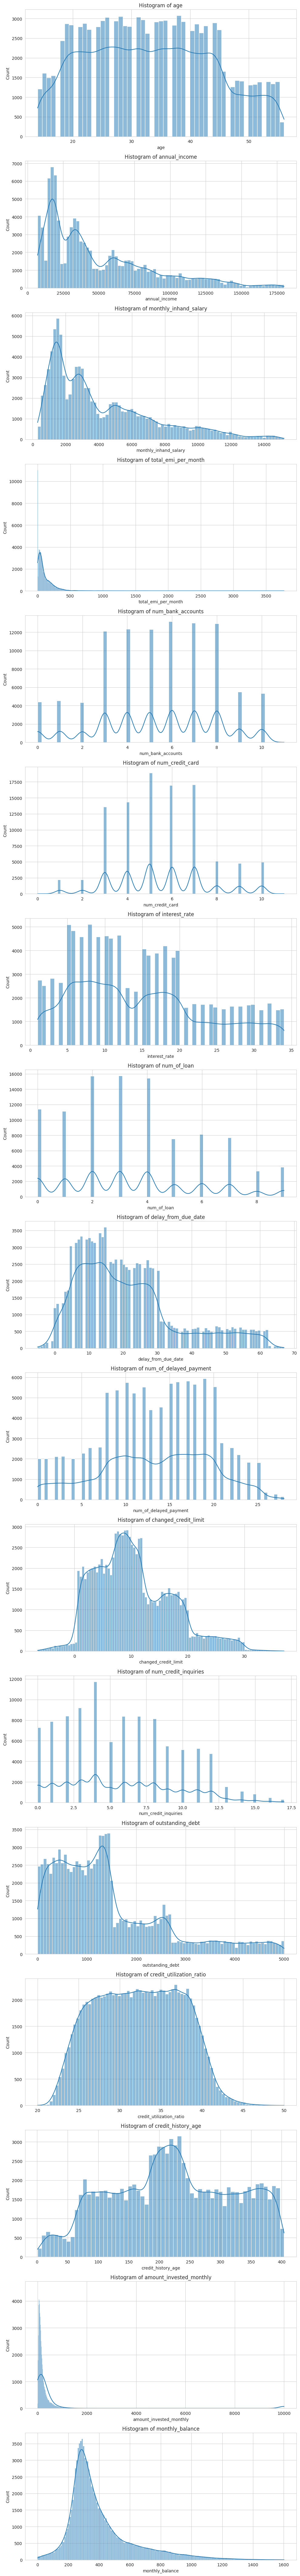

In [8]:
# Get all numerical features
features = numeric_columns[:-1]

# Define the layout for the plots
n_cols = 1  # Specify the number of columns here
n_rows = len(features)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 5))
plt.subplots_adjust(hspace=0.5)

# Plotting
for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[i])  # hue parametresi kaldırıldı
    axes[i].set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()


In [9]:
# Function to detect outliers
def detect_outliers_iqr(df):
    outliers = {}

    # Select only numerical columns
    numeric_df = df.select_dtypes(include=['number'])

    for column in numeric_df.columns:
        # Calculate the first (Q1) and third quartiles (Q3)
        Q1 = numeric_df[column].quantile(0.25)
        Q3 = numeric_df[column].quantile(0.75)

        # Calculate the IQR
        IQR = Q3 - Q1

        # Determine the lower and upper bounds
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Identify outliers
        outlier_mask = (numeric_df[column] < lower_bound) | (numeric_df[column] > upper_bound)
        outliers[column] = numeric_df[column][outlier_mask]

    return outliers

# Detect outliers
outlier_results = detect_outliers_iqr(df)

# Print the results
for column, outlier_values in outlier_results.items():
    if not outlier_values.empty:
        print(f"{column} outliers:")
        print(outlier_values)
    else:
        print(f"For {column} no outliers.")


For age no outliers.
For annual_income no outliers.
For monthly_inhand_salary no outliers.
total_emi_per_month outliers:
50      911.220
51      911.220
52      911.220
53      911.220
54      911.220
          ...  
99627   999.719
99628   999.719
99629   999.719
99630   999.719
99631   999.719
Name: total_emi_per_month, Length: 1338, dtype: float64
For num_bank_accounts no outliers.
For num_credit_card no outliers.
For interest_rate no outliers.
For num_of_loan no outliers.
For delay_from_due_date no outliers.
For num_of_delayed_payment no outliers.
For changed_credit_limit no outliers.
For num_credit_inquiries no outliers.
For outstanding_debt no outliers.
For credit_utilization_ratio no outliers.
For credit_history_age no outliers.
amount_invested_monthly outliers:
18      10000.000
23      10000.000
28      10000.000
54        930.392
55        870.522
           ...   
99919   10000.000
99927    1104.416
99951   10000.000
99973   10000.000
99974   10000.000
Name: amount_invested_

In [10]:
df["credit_score"].value_counts(normalize = True) # 2:Good, 1: Standard, 0: Poor

,proportion
credit_score,
1,0.532
0,0.290
2,0.178


# Data Preprocessing


In [11]:
# List of unique loan values
unique_loan_types = ['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan',
                     'No Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']

# Adding a new column for each unique loan type and checking how many times it appears
for loan_type in unique_loan_types:
    # Replacing '-' and spaces with underscores, converting other characters to lowercase
    cleaned_loan_type = loan_type.replace(' ', '_').replace('-', '_').lower()

    # Counting how many times the loan_type value appears in each row
    df[cleaned_loan_type] = df['type_of_loan'].apply(lambda x: x.count(loan_type))


In [12]:
df = df.drop([
    "id", "customer_id", "name", "ssn", "type_of_loan"], axis=1)

df.head()

,month,age,occupation,annual_income,monthly_inhand_salary,total_emi_per_month,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score,auto_loan,credit_builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,no_loan,not_specified,payday_loan,personal_loan,student_loan
0,January,23,Scientist,19114.120,1824.843,49.575,3,4,3,4,3,7,11.270,4,Good,809.980,26.823,265,No,80.415,High_spent_Small_value_payments,312.494,2,1,1,0,1,0,0,0,0,1,0
1,February,23,Scientist,19114.120,1824.843,49.575,3,4,3,4,-1,7,11.270,4,Good,809.980,31.945,266,No,118.280,Low_spent_Large_value_payments,284.629,2,1,1,0,1,0,0,0,0,1,0
2,March,23,Scientist,19114.120,1824.843,49.575,3,4,3,4,3,7,11.270,4,Good,809.980,28.609,267,No,81.700,Low_spent_Medium_value_payments,331.210,2,1,1,0,1,0,0,0,0,1,0
3,April,23,Scientist,19114.120,1824.843,49.575,3,4,3,4,5,4,6.270,4,Good,809.980,31.378,268,No,199.458,Low_spent_Small_value_payments,223.451,2,1,1,0,1,0,0,0,0,1,0
4,May,23,Scientist,19114.120,1824.843,49.575,3,4,3,4,6,4,11.270,4,Good,809.980,24.797,269,No,41.420,High_spent_Medium_value_payments,341.489,2,1,1,0,1,0,0,0,0,1,0


In [13]:
payment_mapping = {
    'High_spent_Large_value_payments': 6,#Successfully managing large debts provides the most positive contribution to the credit score.
    'High_spent_Medium_value_payments': 5, #Medium-value payments with high spending positively impact the credit score.
    'High_spent_Small_value_payments': 4, #Small payments can negatively affect the credit score if debts accumulate over time.
    'Low_spent_Large_value_payments': 3, #shows quick financial responsibility, positively affecting the credit score.
    'Low_spent_Medium_value_payments': 2, #contributes positively to the credit score by demonstrating debt management.
    'Low_spent_Small_value_payments': 1 #may limit the credit history and provide minimal contribution to the credit score
}


df['payment_behaviour'] = df['payment_behaviour'].map(payment_mapping)

df['payment_behaviour'] = pd.to_numeric(df['payment_behaviour'], downcast='integer')


In [14]:
# Convert the credit_mix column to numerical values
df['credit_mix'] = df['credit_mix'].map({'Good': 2, 'Standard': 1, 'Bad': 0})

df['credit_mix'] = pd.to_numeric(df['credit_mix'], downcast='integer')

In [15]:
# Convert the payment_of_min_amount column to numerical values
df['payment_of_min_amount'] = df['payment_of_min_amount'].map({'Yes': 1, 'No': 0})

df['payment_of_min_amount'] = pd.to_numeric(df['payment_of_min_amount'], downcast='integer')



In [16]:
df = pd.get_dummies(df, columns=['occupation'])

In [17]:
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8
}

#Mapping
df['month'] = df['month'].map(month_map)

df['month'] = pd.to_numeric(df['month'], downcast='integer')

In [18]:
# Separate features and target variable
X = df.drop("credit_score", axis=1)
y = df.credit_score

In [19]:
y.value_counts(normalize=True) # unbalanced data  2:Good, 1: Standard, 0: Poor

,proportion
credit_score,
1,0.532
0,0.290
2,0.178


In [20]:
# smote for unbalanced data
smote = SMOTE()
X, y = smote.fit_resample(X,y)

In [21]:
y.value_counts() # 2:Good, 1: Standard, 0: Poor

,count
credit_score,
2,53174
1,53174
0,53174


In [22]:
df.head()

,month,age,annual_income,monthly_inhand_salary,total_emi_per_month,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score,auto_loan,credit_builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,no_loan,not_specified,payday_loan,personal_loan,student_loan,occupation_Accountant,occupation_Architect,occupation_Developer,occupation_Doctor,occupation_Engineer,occupation_Entrepreneur,occupation_Journalist,occupation_Lawyer,occupation_Manager,occupation_Mechanic,occupation_Media_Manager,occupation_Musician,occupation_Scientist,occupation_Teacher,occupation_Writer
0,1,23,19114.120,1824.843,49.575,3,4,3,4,3,7,11.270,4,2,809.980,26.823,265,0,80.415,4,312.494,2,1,1,0,1,0,0,0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,2,23,19114.120,1824.843,49.575,3,4,3,4,-1,7,11.270,4,2,809.980,31.945,266,0,118.280,3,284.629,2,1,1,0,1,0,0,0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,3,23,19114.120,1824.843,49.575,3,4,3,4,3,7,11.270,4,2,809.980,28.609,267,0,81.700,2,331.210,2,1,1,0,1,0,0,0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,4,23,19114.120,1824.843,49.575,3,4,3,4,5,4,6.270,4,2,809.980,31.378,268,0,199.458,1,223.451,2,1,1,0,1,0,0,0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,5,23,19114.120,1824.843,49.575,3,4,3,4,6,4,11.270,4,2,809.980,24.797,269,0,41.420,5,341.489,2,1,1,0,1,0,0,0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


## Train-Test Splits

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    stratify=y, random_state=42)

In [24]:
df["credit_score"].value_counts()

,count
credit_score,
1,53174
0,28998
2,17828


In [25]:
y_train.value_counts()

,count
credit_score,
0,47857
2,47856
1,47856


In [26]:
# Columns to apply RobustScaler
robust_columns = ['total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']

# Columns to apply StandardScaler (All columns except robust columns)
standard_columns = [col for col in X_train.columns if col not in robust_columns]

# Create the ColumnTransformer
scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('robust', RobustScaler(), robust_columns)])

# Apply to training data
X_train_scaled= scaler.fit_transform(X_train)

# Apply to test data
X_test_scaled = scaler.transform(X_test)


In [27]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)

    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

# ANN Model

In [28]:
tf.random.set_seed(42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=70,
                               restore_best_weights=True)

model.fit(x=X_train_scaled,
          y=y_train,
          validation_data=(X_test_scaled, y_test),
          batch_size=512,
          epochs=750,
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.6160 - loss: 0.9383 - val_accuracy: 0.7392 - val_loss: 0.6378
Epoch 2/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7234 - loss: 0.6796 - val_accuracy: 0.7547 - val_loss: 0.5938
Epoch 3/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7422 - loss: 0.6250 - val_accuracy: 0.7618 - val_loss: 0.5680
Epoch 4/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7524 - loss: 0.5992 - val_accuracy: 0.7664 - val_loss: 0.5517
Epoch 5/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7554 - loss: 0.5841 - val_accuracy: 0.7752 - val_loss: 0.5397
Epoch 6/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7629 - loss: 0.5692 - val_accuracy: 0.7800 - val_loss: 0.5280
Epoch 7/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7684 - loss: 0.5559 - val_accuracy: 0.7859 - val_loss: 0.5138
Epoch 8/750
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7739 - loss: 0.5419 - val_ac

Since the best result is seen at epoch 412 above, I will train the final model for 318 epochs without using early stopping.

<Axes: >

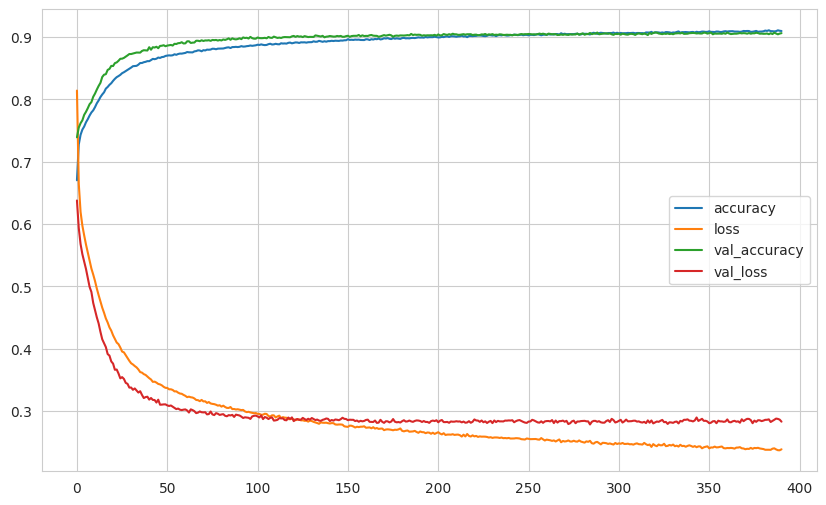

In [29]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [30]:
model.evaluate(X_train_scaled, y_train)

4487/4487 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9456 - loss: 0.1471


[0.14442551136016846, 0.9467781782150269]

In [31]:
eval_metric(model, X_train_scaled, y_train, X_test_scaled, y_test)

4487/4487 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Set:
[[5107  175   35]
 [ 660 4220  438]
 [  32  140 5146]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5317
           1       0.93      0.79      0.86      5318
           2       0.92      0.97      0.94      5318

    accuracy                           0.91     15953
   macro avg       0.91      0.91      0.91     15953
weighted avg       0.91      0.91      0.91     15953


Train Set:
[[47575   272    10]
 [ 4484 40708  2664]
 [   13   198 47645]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47857
           1       0.99      0.85      0.91     47856
           2       0.95      1.00      0.97     47856

    accuracy                           0.95    143569
   macro avg       0.95      0.95      0.95    143569
weighted avg       0.95      0.95      0.95    143569



In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          12,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,036,171 (3.95 MB)

 Trainable params: 344,451 (1.31 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 688,904 (2.63 MB)

# Final Model

In [33]:
print(X.shape)
print(y.shape)

(159522, 46)
(159522,)


In [34]:
# Columns to apply RobustScaler
robust_columns = ['total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']
# Columns to apply StandardScaler (All columns except robust columns)
standard_columns = [col for col in X_train.columns if col not in robust_columns]

# Create the ColumnTransformer
scaler= ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('robust', RobustScaler(), robust_columns)
    ]
)

scaler = scaler.fit(X)



In [35]:
pickle.dump(scaler, open("credit_score_scaler", 'wb'))

In [36]:
X_scaled = scaler.transform(X)

In [37]:
tf.random.set_seed(42)

final_model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
final_model.compile(optimizer = Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

final_model.fit(x=X_scaled,
          y=y,
          batch_size=512,
          epochs=412,
          verbose=1)

Epoch 1/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6314 - loss: 0.9127
Epoch 2/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7279 - loss: 0.6681
Epoch 3/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7443 - loss: 0.6185
Epoch 4/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7533 - loss: 0.5949
Epoch 5/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7596 - loss: 0.5782
Epoch 6/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7661 - loss: 0.5630
Epoch 7/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7705 - loss: 0.5478
Epoch 8/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7754 - loss: 0.5365
Epoch 9/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7826 - loss: 0.5220
Epoch 10/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7876 - loss: 0.5100
Epoch 11/412
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7930 - loss: 0.4981
Epoch 12/412
312/312 ━━━━━━━━━━━━━━━━━━

In [38]:
# Save Model

save_model(final_model, 'final_model_credit_score.keras')

# Final Model Prediction

In [39]:
scaler = pickle.load(open("credit_score_scaler", "rb"))

In [40]:
final_model = load_model('final_model_credit_score.keras')

In [41]:
# Generating random data suitable for statistics using your sample dataset
def generate_synthetic_data(df, num_samples=50):
    synthetic_data = pd.DataFrame()

    for column in df.columns:
        if column != 'credit_score':  # Excluding the target column (e.g., for classification)
            # Extract statistics from your current dataset
            min_val = df[column].min()
            max_val = df[column].max()
            mean_val = df[column].mean()
            std_val = df[column].std()

            # Generate random data suitable for statistics
            synthetic_data[column] = np.random.normal(loc=mean_val, scale=std_val, size=num_samples)

            # Adjust the minimum and maximum values of the generated data to match the original dataset
            synthetic_data[column] = synthetic_data[column].clip(lower=min_val, upper=max_val)

    return synthetic_data

# Generating 50 rows of synthetic data based on the statistics of your current dataset
df_prediction = generate_synthetic_data(df, num_samples=50)


In [49]:
df_prediction

,month,age,annual_income,monthly_inhand_salary,total_emi_per_month,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,auto_loan,credit_builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,no_loan,not_specified,payday_loan,personal_loan,student_loan,occupation_Accountant,occupation_Architect,occupation_Developer,occupation_Doctor,occupation_Engineer,occupation_Entrepreneur,occupation_Journalist,occupation_Lawyer,occupation_Manager,occupation_Mechanic,occupation_Media_Manager,occupation_Musician,occupation_Scientist,occupation_Teacher,occupation_Writer
0,2.490,26.374,127194.023,7333.311,0.000,6.405,1.429,10.206,4.530,15.532,24.743,13.569,0.840,0.155,2228.196,24.359,101.248,0.000,0.000,3.517,196.134,0.000,0.000,0.323,0.000,1.150,0.000,0.759,1.089,0.662,0.756,False,False,0.262,0.058,False,0.250,0.122,False,0.065,0.553,0.129,False,0.016,False,0.090
1,8.000,14.000,43265.259,10315.693,254.777,8.305,6.629,30.602,5.845,24.392,19.231,22.202,9.035,0.000,2247.891,26.904,386.627,0.377,39.915,3.288,651.822,0.000,0.000,0.268,0.605,0.646,0.204,0.455,0.000,1.819,0.345,0.169,0.559,0.421,False,0.650,False,False,False,False,0.221,False,0.615,False,0.121,0.174
2,4.250,32.699,7005.930,4641.920,312.112,5.091,3.126,19.670,1.061,7.164,18.047,16.319,0.000,1.425,2529.804,32.928,291.981,0.677,975.010,4.743,384.713,0.000,0.000,0.113,0.181,0.587,0.173,0.998,0.510,0.495,0.172,0.632,False,0.352,0.123,False,0.096,0.484,False,True,False,0.377,0.690,0.009,False,False
3,1.000,30.440,155458.661,6139.209,0.000,4.586,4.308,33.799,2.373,29.767,13.262,7.584,8.606,1.158,3393.660,40.648,215.313,1.000,0.000,1.000,396.510,0.088,0.908,0.000,0.904,0.925,0.000,0.000,0.321,1.317,0.000,False,False,0.351,False,False,0.324,0.490,False,0.459,False,0.159,0.245,0.389,False,0.444
4,3.080,41.966,132636.367,4108.214,180.677,6.968,3.205,23.050,4.361,19.536,5.181,9.949,0.000,1.988,661.260,34.564,214.317,1.000,1481.046,6.000,797.855,0.000,0.000,0.649,0.284,0.010,0.660,0.302,1.496,0.000,0.000,0.137,0.128,0.438,False,False,False,0.193,0.116,False,False,False,0.029,False,0.074,False
5,2.808,36.772,7005.930,3542.296,340.428,2.922,0.658,10.143,6.737,18.154,23.581,3.242,6.411,1.065,1396.435,34.997,357.833,0.630,2060.601,1.497,472.435,0.000,0.776,0.961,0.000,0.366,0.480,0.000,0.074,0.000,0.687,False,False,False,0.373,0.237,0.678,0.057,False,False,0.137,0.245,0.181,False,0.083,False
6,6.121,24.650,14630.353,2904.138,282.554,8.904,1.261,16.829,9.000,16.442,5.588,14.107,6.039,1.183,2318.664,36.922,77.894,0.824,0.000,1.733,690.275,1.108,0.532,0.787,0.327,0.008,0.000,0.854,0.404,0.885,0.000,0.667,False,False,False,0.338,False,False,0.434,0.229,0.174,0.352,False,False,False,False
7,5.976,21.639,7005.930,523.628,159.834,2.559,0.856,23.094,5.114,13.535,15.704,13.100,4.438,0.817,816.259,34.974,286.871,0.339,480.019,6.000,133.640,0.755,0.000,0.878,0.188,0.126,0.000,0.735,0.363,0.599,0.185,0.068,False,False,0.096,0.365,0.550,0.273,False,0.033,0.376,0.341,0.602,0.241,False,False
8,6.344,43.922,35321.879,6817.473,250.086,3.030,6.296,30.334,2.652,25.421,12.706,8.639,9.203,1.552,1101.358,37.745,250.603,0.526,102.698,3.332,481.348,0.748,0.200,0.298,1.080,0.706,0.596,1.050,0.561,2.220,0.664,False,False,False,False,False,0.320,0.159,0.340,0.340,False,0.245,0.494,0.151,0.331,False
9,6.088,45.321,71080.132,5285.411,183.952,7.502,9.861,24.607,2.521,-4.239,17.658,19.361,8.692,1.838,2808.710,32.016,351.435,0.643,1625.835,3.394,265.636,0.000,0.000,0.238,0.000,0.020,0.631,0.000,0.037,0.000,0.000,False,False,0.310,0.076,0.204,False,0.182,0.025,False,0.662,False,False,False,False,0.142


In [42]:
df_prediction_scaled = scaler.transform(df_prediction)

In [43]:
final_model.predict(df_prediction_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


array([[3.01354397e-02, 9.36585546e-01, 3.32790203e-02],
       [9.99806166e-01, 7.17521331e-09, 1.93755739e-04],
       [1.28594914e-03, 2.28434760e-06, 9.98711824e-01],
       [9.99896288e-01, 9.80970872e-05, 5.60558556e-06],
       [1.51987653e-04, 4.62367870e-02, 9.53611255e-01],
       [4.05255938e-03, 8.53334313e-07, 9.95946586e-01],
       [7.11379111e-01, 7.72875296e-07, 2.88620174e-01],
       [3.49612953e-03, 1.05584171e-07, 9.96503830e-01],
       [8.28683257e-01, 1.71316758e-01, 1.94186107e-08],
       [9.95963216e-01, 3.71154951e-04, 3.66563536e-03],
       [5.29375196e-01, 4.49701112e-08, 4.70624745e-01],
       [9.99490857e-01, 6.55934362e-10, 5.09148522e-04],
       [7.38683681e-04, 5.69150916e-06, 9.99255598e-01],
       [9.99736488e-01, 4.99236230e-05, 2.13624982e-04],
       [5.08368481e-04, 3.59628075e-07, 9.99491215e-01],
       [9.99628186e-01, 2.58078449e-04, 1.13636896e-04],
       [9.94876862e-01, 4.94767865e-03, 1.75353562e-04],
       [9.78260068e-04, 1.98617

In [44]:
y_pred_probabilities = final_model.predict(df_prediction_scaled)

y_pred = y_pred_probabilities.argmax(axis=1) #prediction values



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [45]:
normalized_predictions = tf.nn.softmax(y_pred_probabilities, axis=-1).numpy()#normalized probabilites of each class

In [46]:
pred_df = pd.DataFrame({'pred': y_pred})

# Mapping dictionary for the reverse transformation
mapping = {2: 'Good', 1: 'Standard', 0: 'Poor'}

# Apply the mapping
pred_df["pred"] = pred_df["pred"] .map(mapping)



In [47]:
pred_df["pred_proba_poor"] = normalized_predictions[:,0]
pred_df["pred_proba_standard"] = normalized_predictions[:,1]
pred_df["pred_proba_good"] = normalized_predictions[:,2]
pred_df

,pred,pred_proba_poor,pred_proba_standard,pred_proba_good
0,Standard,0.223,0.553,0.224
1,Poor,0.576,0.212,0.212
2,Good,0.212,0.212,0.576
3,Poor,0.576,0.212,0.212
4,Good,0.215,0.226,0.559
5,Good,0.213,0.212,0.575
6,Poor,0.466,0.229,0.305
7,Good,0.213,0.212,0.575
8,Poor,0.512,0.265,0.223
9,Poor,0.575,0.212,0.213


In [54]:

pred_series = pred_df.iloc[:, 0]

pred_series.name = 'Predictions'

final = pd.concat([df_prediction, pred_series], axis=1)


In [55]:
final

,month,age,annual_income,monthly_inhand_salary,total_emi_per_month,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,auto_loan,credit_builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,no_loan,not_specified,payday_loan,personal_loan,student_loan,occupation_Accountant,occupation_Architect,occupation_Developer,occupation_Doctor,occupation_Engineer,occupation_Entrepreneur,occupation_Journalist,occupation_Lawyer,occupation_Manager,occupation_Mechanic,occupation_Media_Manager,occupation_Musician,occupation_Scientist,occupation_Teacher,occupation_Writer,Predictions
0,2.490,26.374,127194.023,7333.311,0.000,6.405,1.429,10.206,4.530,15.532,24.743,13.569,0.840,0.155,2228.196,24.359,101.248,0.000,0.000,3.517,196.134,0.000,0.000,0.323,0.000,1.150,0.000,0.759,1.089,0.662,0.756,False,False,0.262,0.058,False,0.250,0.122,False,0.065,0.553,0.129,False,0.016,False,0.090,Standard
1,8.000,14.000,43265.259,10315.693,254.777,8.305,6.629,30.602,5.845,24.392,19.231,22.202,9.035,0.000,2247.891,26.904,386.627,0.377,39.915,3.288,651.822,0.000,0.000,0.268,0.605,0.646,0.204,0.455,0.000,1.819,0.345,0.169,0.559,0.421,False,0.650,False,False,False,False,0.221,False,0.615,False,0.121,0.174,Poor
2,4.250,32.699,7005.930,4641.920,312.112,5.091,3.126,19.670,1.061,7.164,18.047,16.319,0.000,1.425,2529.804,32.928,291.981,0.677,975.010,4.743,384.713,0.000,0.000,0.113,0.181,0.587,0.173,0.998,0.510,0.495,0.172,0.632,False,0.352,0.123,False,0.096,0.484,False,True,False,0.377,0.690,0.009,False,False,Good
3,1.000,30.440,155458.661,6139.209,0.000,4.586,4.308,33.799,2.373,29.767,13.262,7.584,8.606,1.158,3393.660,40.648,215.313,1.000,0.000,1.000,396.510,0.088,0.908,0.000,0.904,0.925,0.000,0.000,0.321,1.317,0.000,False,False,0.351,False,False,0.324,0.490,False,0.459,False,0.159,0.245,0.389,False,0.444,Poor
4,3.080,41.966,132636.367,4108.214,180.677,6.968,3.205,23.050,4.361,19.536,5.181,9.949,0.000,1.988,661.260,34.564,214.317,1.000,1481.046,6.000,797.855,0.000,0.000,0.649,0.284,0.010,0.660,0.302,1.496,0.000,0.000,0.137,0.128,0.438,False,False,False,0.193,0.116,False,False,False,0.029,False,0.074,False,Good
5,2.808,36.772,7005.930,3542.296,340.428,2.922,0.658,10.143,6.737,18.154,23.581,3.242,6.411,1.065,1396.435,34.997,357.833,0.630,2060.601,1.497,472.435,0.000,0.776,0.961,0.000,0.366,0.480,0.000,0.074,0.000,0.687,False,False,False,0.373,0.237,0.678,0.057,False,False,0.137,0.245,0.181,False,0.083,False,Good
6,6.121,24.650,14630.353,2904.138,282.554,8.904,1.261,16.829,9.000,16.442,5.588,14.107,6.039,1.183,2318.664,36.922,77.894,0.824,0.000,1.733,690.275,1.108,0.532,0.787,0.327,0.008,0.000,0.854,0.404,0.885,0.000,0.667,False,False,False,0.338,False,False,0.434,0.229,0.174,0.352,False,False,False,False,Poor
7,5.976,21.639,7005.930,523.628,159.834,2.559,0.856,23.094,5.114,13.535,15.704,13.100,4.438,0.817,816.259,34.974,286.871,0.339,480.019,6.000,133.640,0.755,0.000,0.878,0.188,0.126,0.000,0.735,0.363,0.599,0.185,0.068,False,False,0.096,0.365,0.550,0.273,False,0.033,0.376,0.341,0.602,0.241,False,False,Good
8,6.344,43.922,35321.879,6817.473,250.086,3.030,6.296,30.334,2.652,25.421,12.706,8.639,9.203,1.552,1101.358,37.745,250.603,0.526,102.698,3.332,481.348,0.748,0.200,0.298,1.080,0.706,0.596,1.050,0.561,2.220,0.664,False,False,False,False,False,0.320,0.159,0.340,0.340,False,0.245,0.494,0.151,0.331,False,Poor
9,6.088,45.321,71080.132,5285.411,183.952,7.502,9.861,24.607,2.521,-4.239,17.658,19.361,8.692,1.838,2808.710,32.016,351.435,0.643,1625.835,3.394,265.636,0.000,0.000,0.238,0.000,0.020,0.631,0.000,0.037,0.000,0.000,False,False,0.310,0.076,0.204,False,0.182,0.025,False,0.662,False,False,False,False,0.142,Poor


In [56]:
final.to_csv('final_output.csv', index=False)